experimental study of "saddle point formulation"

impact of architecture on robustness; "model capacity important"

train on MNIST, CIFAR10; robust to adversarial attacks. 89% accuracy on MNIST, 46% on CIFAR10

focus on $\ell_\infty$ ball perturbations

Saddle point problem

$$
\min_{\theta} \rho(\theta) \quad \mathrm{where} \quad
    \rho(\theta) = \mathbb{E}_{(x,y) \sim \mathcal{D}} \left[
        \max_{\delta \in \mathcal{S}} L(\theta, x + \delta, y)
    \right]
$$

($\mathcal{S}$ is an $\ell_\infty$-ball around $x$).

In [72]:
import tensorflow as tf
import tensorflow_probability as tfp
import warnings
mnist = tf.keras.datasets.mnist

%pylab inline
warnings.filterwarnings('ignore')
mpl.rc('image', cmap='gray')

Populating the interactive namespace from numpy and matplotlib


In [73]:
(x_train, y_train),(x_test, y_test) = mnist.load_data()

0 73.45848 0.1792
1000 0.07631419 0.9524
2000 0.010186126 0.9578
3000 0.04125679 0.9646
4000 0.10215825 0.9641
5000 0.076887876 0.973
6000 0.053298973 0.9708
7000 0.018914487 0.9675
8000 0.0137179475 0.9749
9000 0.007324502 0.9768
9999 0.0014312956 0.9751


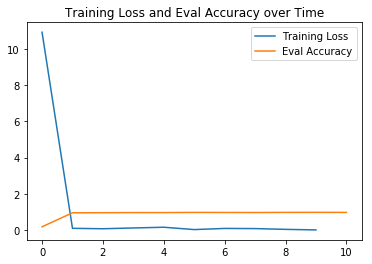

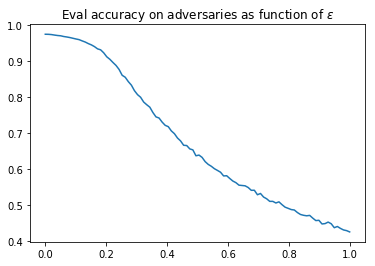

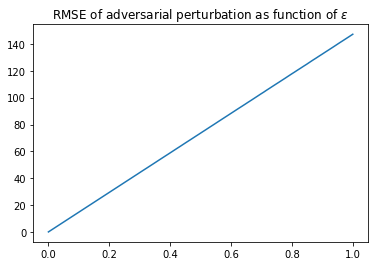

In [122]:
def _(sess):
  BATCH_SIZE=128

  net = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation=tf.nn.relu),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(512, activation=tf.nn.relu),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(10, activation=None),
  ])

  x = tf.placeholder(tf.float32, [None, 28, 28], 'x')
  y = tf.placeholder(tf.uint8, [None], 'y')
  logits = net(x)
  loss = tf.losses.softmax_cross_entropy(
    tf.one_hot(y, 10), logits)
  predictions = tf.cast(tf.argmax(tf.nn.softmax(logits), axis=-1), tf.uint8)

  # Do some shape gymnastics to let us vectorize the computation of adversarial accuracies later
  num_examples = tf.placeholder_with_default(np.int32(10000), [], 'num_examples')
  eval_accuracy = tf.reduce_mean(tf.cast(
    tf.equal(
      tf.reshape(y, [-1, num_examples]),
      tf.reshape(predictions, [-1, num_examples])),
    tf.float32), axis=-1)

  adam = tf.train.AdamOptimizer()
  train_op = adam.minimize(loss)

  NUM_ITERS = 10000
  EVAL_INTERVAL = 1000
  losses_ = np.zeros(NUM_ITERS, np.float32)
  eval_loss_ = np.zeros(0, np.float32)
  eval_accuracy_ = np.zeros(0, np.float32)

  sess.run(tf.global_variables_initializer())
  for i in range(NUM_ITERS):
    batch_indices = np.random.randint(0, x_train.shape[0], BATCH_SIZE)
    feed_dict = {
      x: x_train[batch_indices, ...],
      y: y_train[batch_indices, ...],
    }
    _, losses_[i] = sess.run([train_op, loss], feed_dict)
    if i % EVAL_INTERVAL == 0 or i + 1 == NUM_ITERS:
      eval_accuracy_ = np.append(
        eval_accuracy_,
        sess.run(eval_accuracy, feed_dict={x: x_test, y: y_test}))
      print(i, losses_[i], eval_accuracy_[-1])
  plt.plot(losses_[10::EVAL_INTERVAL], label='Training Loss')
  plt.plot(eval_accuracy_, label='Eval Accuracy')
  plt.title("Training Loss and Eval Accuracy over Time")
  plt.legend()
  plt.show()

  NUM_EPSILONS = 100
  epsilons = np.linspace(0., 1., NUM_EPSILONS)
  adversaries = (x_test +
                 epsilons[..., None, None, None] *
                 np.random.uniform(
                   0., 255., size=[NUM_EPSILONS, x_test.shape[0], 28, 28]))

  rmse_ = np.sqrt(np.mean(np.reshape((x_test - adversaries)**2, [NUM_EPSILONS, -1]), axis=-1))
  adversarial_eval_accuracies_ = sess.run(
    eval_accuracy,
    feed_dict={x: adversaries.reshape([-1, 28, 28]),
               y: np.stack([y_test]*NUM_EPSILONS).reshape([-1])})
  plt.plot(epsilons, adversarial_eval_accuracies_)
  plt.title(r"Eval accuracy on adversaries as function of $\epsilon$")
  plt.show()
  plt.plot(epsilons, rmse_)
  plt.title(r"RMSE of adversarial perturbation as function of $\epsilon$")
  plt.show()

with tf.Graph().as_default(), tf.Session() as sess:
  _(sess)